In [1]:
# need to install skorch if you haven't done that
!pip install skorch

In [2]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier

# We need to import some Sci-kit Learn modules for computation purposes.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)

In [3]:
'''
Import the data
'''
from torch.nn.functional import normalize
# select the root = ....

mnist = torchvision.datasets.MNIST(root = '/data', 
                                   train = True, 
                                   transform = transforms.ToTensor(),  
                                   download = True)

test_dataset = torchvision.datasets.MNIST(root = '/data', 
                                          train = False, 
                                          transform = transforms.ToTensor())


X_train = mnist.data
y_train = mnist.targets

X_test = test_dataset.data
y_test = test_dataset.targets
print(list(X_train.size()))

'''
Step -- Normalize each input from [0.0,1.0] range
'''
# print(X_train.float().mean(), X_train.float().std())
X_train_norm = torch.nn.functional.normalize(X_train.float())
X_test_norm = torch.nn.functional.normalize(X_test.float())

print(X_train_norm.dim())


'''
Step -- Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''


from torch.utils.data import DataLoader
loaders = {
    'X_train' : torch.utils.data.DataLoader(X_train_norm, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    'y_train' : torch.utils.data.DataLoader(y_train, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'X_test'  : torch.utils.data.DataLoader(X_test_norm, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
           
    'y_test'  : torch.utils.data.DataLoader(y_test, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

[60000, 28, 28]
3


{'X_train': <torch.utils.data.dataloader.DataLoader at 0x2268d3008b0>,
 'y_train': <torch.utils.data.dataloader.DataLoader at 0x2268d300a90>,
 'X_test': <torch.utils.data.dataloader.DataLoader at 0x2268d300df0>,
 'y_test': <torch.utils.data.dataloader.DataLoader at 0x2268d300ee0>}

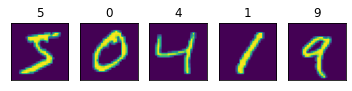

In [4]:
'''
Will do some basic plotting to get a feel for the data that we imported.

'''

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())
        
plot_example(X_train, y_train)

In [5]:
# build your CNN 
class CNN(nn.Module):
    def __init__(self, dropout = 0.4):
        super(CNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 16, 5)
        self.pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, 5)
        self.pool2 = torch.nn.MaxPool2d(2, stride=2)
        
        self.fc1 = torch.nn.Linear(512, 256)
        self.drop1 = torch.nn.Dropout(dropout)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)

    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''
        
        output = torch.relu(self.conv1(x))
        output = self.pool1(output)
        output = torch.relu(self.conv2(output))
        output = self.pool2(output)
        
        output = output.reshape(-1, 512)
        output = torch.relu(self.fc1(output))
        output = self.drop1(output)
        output = torch.relu(self.fc2(output))
        output = self.drop2(output)
        output = self.fc3(output)
        
        output = torch.Softmax(output)
        

        return output

In [6]:
# Adding L1 regularization

class RegularizedNet(NeuralNetClassifier):
    
    ''''''
    
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
    
    ''' *** Explain -- What is the following method doing? Explain in detail in the main pdf ***'''
    
    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred, y_true, X = X, training = training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [7]:
# print out the structure of the model 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__ = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNet(module = CNN, 
                     max_epochs = 10,
                     criterion = torch.nn.NLLLoss, 
                     optimizer = torch.optim.SGD,
                     lr = 0.1, 
                     lambda1 = 0,
                     module__dropout = 0.4,
                     optimizer__weight_decay = 0,
                     device = device)

In [9]:
'''Step - train the network'''

cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Look how your loss is going down as well as the validation accuracy is increasing 
'''

RuntimeError: Given groups=1, weight of size [16, 1, 5, 5], expected input[1, 128, 28, 28] to have 1 channels, but got 128 channels instead

In [ ]:
'''Step - Predict for the test set and print the final accuracy score, your validation accuracy obtained in the previous
cell should be similar to the accuracy in the test set
'''
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)